In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import itertools
my_SIFT_instance = cv2.SIFT_create()
list_images = [cv2.imread(file) for file in glob.glob("C:\\Users\\LFF\\ELEC474\\office2\\*.jpg")]
output = cv2.imread("output.jpg")
output = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
print(len(list_images))

29


29


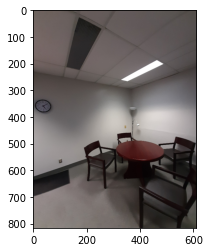

In [2]:
list_image = []
for i in range(len(list_images)):
    list_images[i] = cv2.cvtColor(list_images[i],cv2.COLOR_BGR2RGB)
    list_images[i] = cv2.resize(list_images[i], (int(list_images[i].shape[1] / 4), int(list_images[i].shape[0] / 4)))
    list_image.append(list_images[i])


list_images=list_image
print(len(list_images))
plt.imshow(list_images[4])

In [3]:
def loweratiomatch(img1,img2):
    kp1, des1 = my_SIFT_instance.detectAndCompute(img1,None)
    kp2, des2 = my_SIFT_instance.detectAndCompute(img2,None)
    fbm = cv2.FlannBasedMatcher()
    matches = fbm.knnMatch(des1,des2, k=2)
    good = []
    goodlist=[]
    for m,n in matches:
        if(m.distance < 0.7*n.distance):
            good.append([m])
            goodlist.append(m)
    goodcount  =  len(goodlist)
    loweresult = [kp1,kp2,des1,des2,good,goodlist,goodcount]
    return loweresult


def get_best(imgs):
    combine_list=[]
    for i in range (28, 0, -1):
        cur_list =[]
        for j in range(i-1, -1,-1 ):
            cur_list.append([i,j])
        combine_list.append(cur_list)
        
    result =[]
    for item in combine_list[-1:]:
        for item_1 in item:
            item_1.append(loweratiomatch(imgs[item_1[0]],imgs[item_1[1]])[6])
        item.sort(key=lambda x:x[2],reverse=True)
        result.append(item[0])
    return result

result = get_best(list_images)


for i in range(len(result)):
    result[i].pop(2)
result.reverse()
print(result)

[[1, 0]]


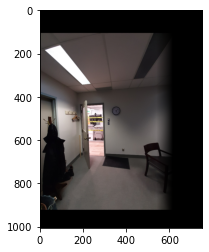

In [4]:
def transform(img1,img2):
    result = loweratiomatch(img1,img2)
    goodmatch= result[4]
    ref_pts = np.float32([result[0][m.queryIdx].pt for m in result[5]]).reshape(-1, 1, 2)
    img_pts = np.float32([result[1][m.trainIdx].pt for m in result[5]]).reshape(-1, 1, 2)
    transformation_matrix, rigid_mask = cv2.findHomography(ref_pts, img_pts, method = cv2.RANSAC)
    
    return (goodmatch,transformation_matrix, rigid_mask)

def blendingMask(height, width, barrier, smoothing_window, left_biased=True):
    assert barrier < width
    mask = np.zeros((height, width))

    offset = int(smoothing_window / 2)
    try:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset + 1).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset + 1).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1
    except BaseException:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1

    return cv2.merge([mask, mask, mask])


def panoramaBlending(dst_img_rz, src_img_warped, width_dst, side, showstep=False):
    """Given two aligned images @dst_img and @src_img_warped, and the @width_dst is width of dst_img
    before resize, that indicates where there is the discontinuity between the images,
    this function produce a smoothed transient in the overlapping.
    @smoothing_window is a parameter that determines the width of the transient
    left_biased is a flag that determines whether it is masked the left image,
    or the right one"""

    h, w, _ = dst_img_rz.shape
    smoothing_window = int(width_dst / 8)
    barrier = width_dst - int(smoothing_window / 2)
    mask1 = blendingMask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=True
    )
    mask2 = blendingMask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=False
    )

    if showstep:
        nonblend = src_img_warped + dst_img_rz
    else:
        nonblend = None
        leftside = None
        rightside = None

    if side == "left":
        dst_img_rz = cv2.flip(dst_img_rz, 1)
        src_img_warped = cv2.flip(src_img_warped, 1)
        dst_img_rz = dst_img_rz * mask1
        src_img_warped = src_img_warped * mask2
        pano = src_img_warped + dst_img_rz
        pano = cv2.flip(pano, 1)
        if showstep:
            leftside = cv2.flip(src_img_warped, 1)
            rightside = cv2.flip(dst_img_rz, 1)
    else:
        dst_img_rz = dst_img_rz * mask1
        src_img_warped = src_img_warped * mask2
        pano = src_img_warped + dst_img_rz
        if showstep:
            leftside = dst_img_rz
            rightside = src_img_warped

    return pano, nonblend, leftside, rightside


def warpTwoImages(src_img, dst_img, showstep=False):

    # generate Homography matrix
    _,H, _ = transform(src_img, dst_img)

    # get height and width of two images
    height_src, width_src = src_img.shape[:2]
    height_dst, width_dst = dst_img.shape[:2]

    # extract conners of two images: top-left, bottom-left, bottom-right, top-right
    pts1 = np.float32(
        [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
    ).reshape(-1, 1, 2)
    pts2 = np.float32(
        [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
    ).reshape(-1, 1, 2)

    try:
        # aply homography to conners of src_img
        pts1_ = cv2.perspectiveTransform(pts1, H)
        pts = np.concatenate((pts1_, pts2), axis=0)

        # find max min of x,y coordinate
        [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
        [_, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
        t = [-xmin, -ymin]

        # top left point of image which apply homography matrix, which has x coordinate < 0, has side=left
        # otherwise side=right
        # source image is merged to the left side or right side of destination image
        if pts[0][0][0] < 0:
            side = "left"
            width_pano = width_dst + t[0]
        else:
            width_pano = int(pts1_[3][0][0])
            side = "right"
        height_pano = ymax - ymin

        # Translation
        # https://stackoverflow.com/a/20355545
        Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
        src_img_warped = cv2.warpPerspective(
            src_img, Ht.dot(H), (width_pano, height_pano)
        )
        # generating size of dst_img_rz which has the same size as src_img_warped
        dst_img_rz = np.zeros((height_pano, width_pano, 3))
        if side == "left":
            dst_img_rz[t[1] : height_src + t[1], t[0] : width_dst + t[0]] = dst_img
        else:
            dst_img_rz[t[1] : height_src + t[1], :width_dst] = dst_img

        # blending panorama
        pano, nonblend, leftside, rightside = panoramaBlending(
            dst_img_rz, src_img_warped, width_dst, side, showstep=showstep
        )

        # croping black region
        pano = crop(pano, height_dst, pts)
        return pano, nonblend, leftside, rightside
    except BaseException:
        raise Exception("Please try again with another image set!")


def multiStitching(list_images):
    """assume that the list_images was supplied in left-to-right order, choose middle image then
    divide the array into 2 sub-arrays, left-array and right-array. Stiching middle image with each
    image in 2 sub-arrays. @param list_images is The list which containing images, @param smoothing_window is
    the value of smoothy side after stitched, @param output is the folder which containing stitched image
    """
    n = int(len(list_images) / 2 + 0.5)
    left = list_images[:n]
    right = list_images[n - 1 :]
    right.reverse()
    while len(left) > 1:
        dst_img = left.pop()
        src_img = left.pop()
        left_pano, _, _, _ = warpTwoImages(src_img, dst_img)
        left_pano = left_pano.astype("uint8")
        left.append(left_pano)

    while len(right) > 1:
        dst_img = right.pop()
        src_img = right.pop()
        right_pano, _, _, _ = warpTwoImages(src_img, dst_img)
        right_pano = right_pano.astype("uint8")
        right.append(right_pano)

    # if width_right_pano > width_left_pano, Select right_pano as destination. Otherwise is left_pano
    if right_pano.shape[1] >= left_pano.shape[1]:
        fullpano, _, _, _ = warpTwoImages(left_pano, right_pano)
    else:
        fullpano, _, _, _ = warpTwoImages(right_pano, left_pano)
    return fullpano


def crop(panorama, h_dst, conners):
    """crop panorama based on destination.
    @param panorama is the panorama
    @param h_dst is the hight of destination image
    @param conner is the tuple which containing 4 conners of warped image and
    4 conners of destination image"""
    # find max min of x,y coordinate
    [xmin, ymin] = np.int32(conners.min(axis=0).ravel() - 0.5)
    t = [-xmin, -ymin]
    conners = conners.astype(int)

    # conners[0][0][0] is the X coordinate of top-left point of warped image
    # If it has value<0, warp image is merged to the left side of destination image
    # otherwise is merged to the right side of destination image
    if conners[0][0][0] < 0:
        n = abs(-conners[1][0][0] + conners[0][0][0])
        panorama = panorama[t[1] : h_dst + t[1], n:, :]
    else:
        if conners[2][0][0] < conners[3][0][0]:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[2][0][0], :]
        else:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[3][0][0], :]
    return panorama

def convertResult(img):
    '''Because of your images which were loaded by opencv, 
    in order to display the correct output with matplotlib, 
    you need to reduce the range of your floating point image from [0,255] to [0,1] 
    and converting the image from BGR to RGB:'''
    img = np.array(img,dtype=float)/float(255)
    return img
    

pano,non_blend,left_side,right_side=warpTwoImages(list_images[result[0][0]],list_images[result[0][1]],True)
plt.imshow(convertResult(left_side))

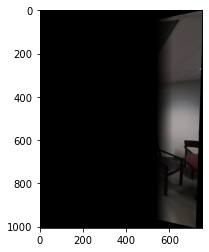

In [5]:
plt.imshow(convertResult(right_side))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


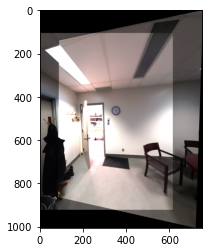

In [6]:
plt.imshow(convertResult(non_blend))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


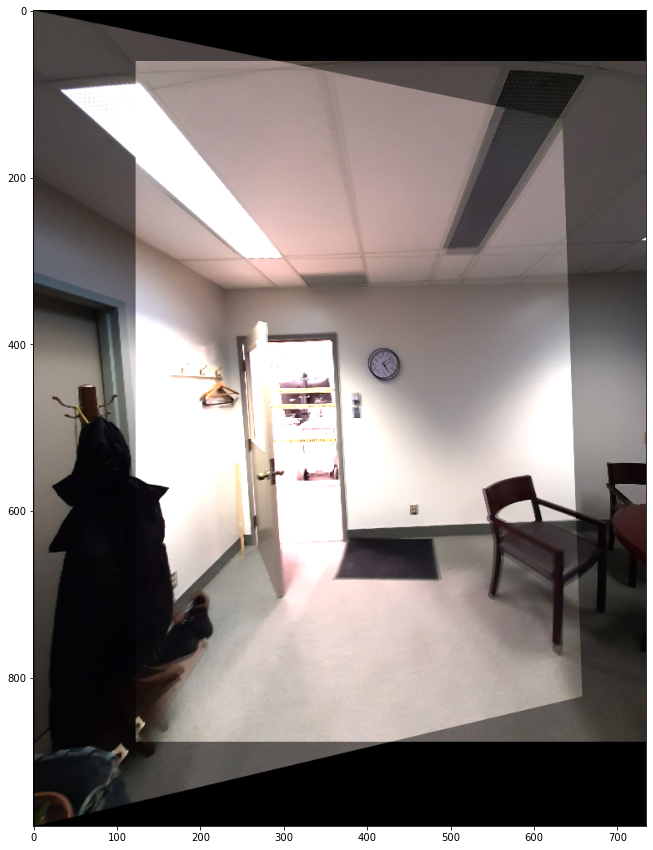

In [7]:
_,non_blend2,_,_=warpTwoImages(list_images[0],list_images[1],True)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(non_blend2))

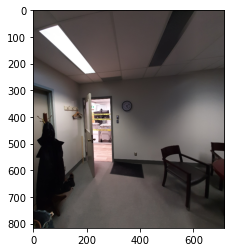

In [8]:
plt.imshow(convertResult(pano))

In [14]:
panorama=multiStitching(list_images[2:10])
plt.figure(figsize=(15,15))
plt.imshow(convertResult(panorama))

k = convertResult(panorama)


Exception: Please try again with another image set!

In [ ]:
_,non_blend2,_,_=warpTwoImages(k,output,True)
plt.imshow(convertResult(non_blend2))